In [28]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

In [54]:
import pickle

In [29]:
# Carregando o dataset
df = pd.read_csv('./diabetes_prediction_dataset.csv')

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [31]:
df.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
age,100000.0,41.89,22.52,0.08,24.00,43.00,60.00,80.00
hypertension,100000.0,0.07,0.26,0.00,0.00,0.00,0.00,1.00
heart_disease,100000.0,0.04,0.19,0.00,0.00,0.00,0.00,1.00
bmi,100000.0,27.32,6.64,10.01,23.63,27.32,29.58,95.69
HbA1c_level,100000.0,5.53,1.07,3.50,4.80,5.80,6.20,9.00
blood_glucose_level,100000.0,138.06,40.71,80.00,100.00,140.00,159.00,300.00
diabetes,100000.0,0.08,0.28,0.00,0.00,0.00,0.00,1.00


In [32]:
df['gender'].value_counts()

gender
Female    58552
Male      41430
Other        18
Name: count, dtype: int64

In [33]:
df['smoking_history'].value_counts()

smoking_history
No Info        35816
never          35095
former          9352
current         9286
not current     6447
ever            4004
Name: count, dtype: int64

In [34]:
df['diabetes'].value_counts()

diabetes
0    91500
1     8500
Name: count, dtype: int64

In [35]:
# Mapeamento dos valores categóricos
gender_map = {'Male': 0, 'Female': 1, 'Other': 2}
df['gender'] = df['gender'].map(gender_map)

In [36]:
# Substituir os valores "outros" (representados pelo valor 2) pela moda
mode_gender = df['gender'].mode()[0]
df['gender'] = df['gender'].replace(2, mode_gender)

In [37]:
smoking_map = {
    'No Info': 0,
    'never': 1,
    'former': 2,
    'not current': 3,
    'ever': 4,
    'current': 5
}
df['smoking_history'] = df['smoking_history'].map(smoking_map)

In [38]:
# Separando as features (X) e a variável alvo (y)
X = df.drop(columns=['diabetes'], axis=1)
y = df['diabetes']

In [39]:
# Aplicando SMOTE para balancear os dados
smote = SMOTE(random_state=25)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [40]:
# Dividindo os dados em treino e teste
Xtrain, Xtest, ytrain, ytest = train_test_split(X_resampled, y_resampled, test_size=0.1, stratify=y_resampled, random_state=25)

In [41]:
# Criando o modelo de Regressão Logística
lr = LogisticRegression(random_state=1000)

In [42]:
# Treinando o modelo
lr.fit(Xtrain, ytrain)

LogisticRegression(random_state=1000)

In [43]:
# Avaliando o modelo
ypred = lr.predict(Xtest)
ypred_proba = lr.predict_proba(Xtest)[:, 1]

In [44]:
# Encontrando o threshold ótimo
fpr, tpr, thresholds = roc_curve(ytest, ypred_proba)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f'O threshold ótimo é {optimal_threshold:.2f}')

O threshold ótimo é 0.50


In [45]:
# Ajustando as previsões com o novo threshold
ypred_adjusted = (ypred_proba >= optimal_threshold).astype(int)

# Relatório de classificação
print(f'Classificação (Logistic Regression ajustado):\n{classification_report(ytest, ypred_adjusted, target_names=["Non-Diabetic", "Diabetic"])}')

Classificação (Logistic Regression ajustado):
              precision    recall  f1-score   support

Non-Diabetic       0.90      0.89      0.90      9150
    Diabetic       0.90      0.90      0.90      9150

    accuracy                           0.90     18300
   macro avg       0.90      0.90      0.90     18300
weighted avg       0.90      0.90      0.90     18300



In [46]:
# AUC-ROC Score
roc_auc = roc_auc_score(ytest, ypred_proba)
print(f'AUC-ROC Score: {roc_auc:.4f}')

AUC-ROC Score: 0.9664


In [47]:
# Matriz de Confusão
conf_matrix = confusion_matrix(ytest, ypred_adjusted)
print(f'Matriz de Confusão:\n{conf_matrix}')

Matriz de Confusão:
[[8189  961]
 [ 953 8197]]


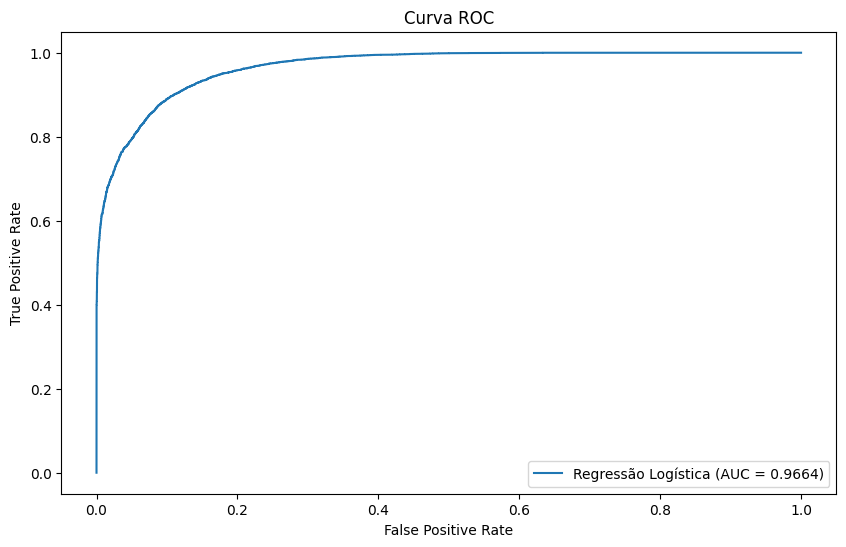

In [48]:
# Plotando a curva ROC
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'Regressão Logística (AUC = {roc_auc:.4f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc='best')
plt.show()

In [49]:
# Testando com Random Forest
rf = RandomForestClassifier(random_state=1000)
rf.fit(Xtrain, ytrain)
ypred_rf = rf.predict(Xtest)
ypred_proba_rf = rf.predict_proba(Xtest)[:, 1]

print(f'Classificação (Random Forest):\n{classification_report(ytest, ypred_rf, target_names=["Non-Diabetic", "Diabetic"])}')

Classificação (Random Forest):
              precision    recall  f1-score   support

Non-Diabetic       0.97      0.98      0.97      9150
    Diabetic       0.98      0.97      0.97      9150

    accuracy                           0.97     18300
   macro avg       0.97      0.97      0.97     18300
weighted avg       0.97      0.97      0.97     18300



In [50]:
# Função para realizar o teste de previsão com base em novos dados
def result_test(new_pred):
    result = lr.predict(new_pred)[0]
    result_prob = round(lr.predict_proba(new_pred)[:,1][0], 4)
    
    if result == 1:
        # Se o resultado for 1, mostramos a probabilidade de ser diabético
        print(f'Resultado: {result} | Existe {result_prob*100}% chance de o(a) paciente ser diabético.')
    else:
        # Se o resultado for 0, mostramos a probabilidade de não ser diabético
        print(f'Resultado: {result} | Existe {(1 - result_prob)*100}% chance de o(a) paciente não ser diabético.')

In [51]:
# Exemplos de dados para testar a previsão (sem escalonamento)
test_samples = [
    np.array([0, 45.0, 1, 0, 1, 30.50, 6.0, 150]).reshape(1, -1),
    np.array([1, 55.0, 0, 1, 4, 28.70, 7.5, 170]).reshape(1, -1),
    np.array([0, 35.0, 0, 0, 0, 24.60, 5.2, 110]).reshape(1, -1),
    np.array([1, 25.0, 0, 0, 2, 26.50, 4.8, 95]).reshape(1, -1),
    np.array([1, 65.0, 1, 1, 3, 29.80, 6.8, 210]).reshape(1, -1)
]

In [52]:
# Testar todos os exemplos
for i, sample in enumerate(test_samples):
    print(f"Teste {i+1}:")
    result_test(sample)
    print()

Teste 1:
Resultado: 0 | Existe 65.64999999999999% chance de o(a) paciente não ser diabético.

Teste 2:
Resultado: 1 | Existe 88.83% chance de o(a) paciente ser diabético.

Teste 3:
Resultado: 0 | Existe 99.22999999999999% chance de o(a) paciente não ser diabético.

Teste 4:
Resultado: 0 | Existe 99.97% chance de o(a) paciente não ser diabético.

Teste 5:
Resultado: 1 | Existe 88.46000000000001% chance de o(a) paciente ser diabético.



In [55]:
pickle.dump(lr, open('modelo_treinado.pkl', 'wb'))

In [56]:
model = pickle.load(open('modelo_treinado.pkl', 'rb'))